# Fake News Detection with DistilBERT & MobileBERT - Optimized

## Model Options:
1. **DistilBERT**: Faster, smaller, good performance
2. **MobileBERT**: Optimized for mobile devices, even faster inference

## Optimizations:
- MPS backend for GPU acceleration
- Memory-efficient training
- Early stopping to prevent overfitting
- Progress tracking and timing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import torch
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    MobileBertTokenizer, MobileBertForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from datasets import Dataset
import warnings
import time
from collections import defaultdict
warnings.filterwarnings('ignore')

# Check MPS availability
print("🖥️  Hardware Check:")
print(f"PyTorch version: {torch.__version__}")
print(f"MPS (Apple Silicon GPU) available: {torch.backends.mps.is_available()}")
print(f"CPU cores: {torch.get_num_threads()}")

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("✅ Libraries imported successfully!")

🖥️  Hardware Check:
PyTorch version: 2.9.1
MPS (Apple Silicon GPU) available: True
CPU cores: 4
Using device: mps
✅ Libraries imported successfully!


## Step 1: Model Configuration

Choose between DistilBERT and MobileBERT based on needs:
- DistilBERT: Better accuracy, moderate speed
- MobileBERT: Faster inference, mobile-optimized

In [2]:
MODEL_CONFIG = {
    "distilbert": {
        "name": "DistilBERT",
        "model_class": DistilBertForSequenceClassification,
        "tokenizer_class": DistilBertTokenizer,
        "pretrained_name": "distilbert-base-uncased",
        "description": "Smaller, faster version of BERT with 40% fewer parameters"
    },
    "mobilebert": {
        "name": "MobileBERT",
        "model_class": MobileBertForSequenceClassification,
        "tokenizer_class": MobileBertTokenizer,
        "pretrained_name": "google/mobilebert-uncased",
        "description": "Mobile-optimized BERT variant for fast inference"
    }
}

# Choose model here! Which one to Train
SELECTED_MODEL = "mobilebert" 

if SELECTED_MODEL not in MODEL_CONFIG:
    print(f"❌ Invalid model selection. Using DistilBERT as default.")
    SELECTED_MODEL = "distilbert"

config = MODEL_CONFIG[SELECTED_MODEL]
print(f"🎯 Selected Model: {config['name']}")
print(f"📝 Description: {config['description']}")
print(f"🔧 Pretrained: {config['pretrained_name']}")

🎯 Selected Model: MobileBERT
📝 Description: Mobile-optimized BERT variant for fast inference
🔧 Pretrained: google/mobilebert-uncased


## Step 2: Data Loading and Exploration

📊 Loading dataset...
✅ Dataset loaded in 1.41 seconds
Dataset shape: (44919, 4)
Label distribution:
label
0    23502
1    21417
Name: count, dtype: int64


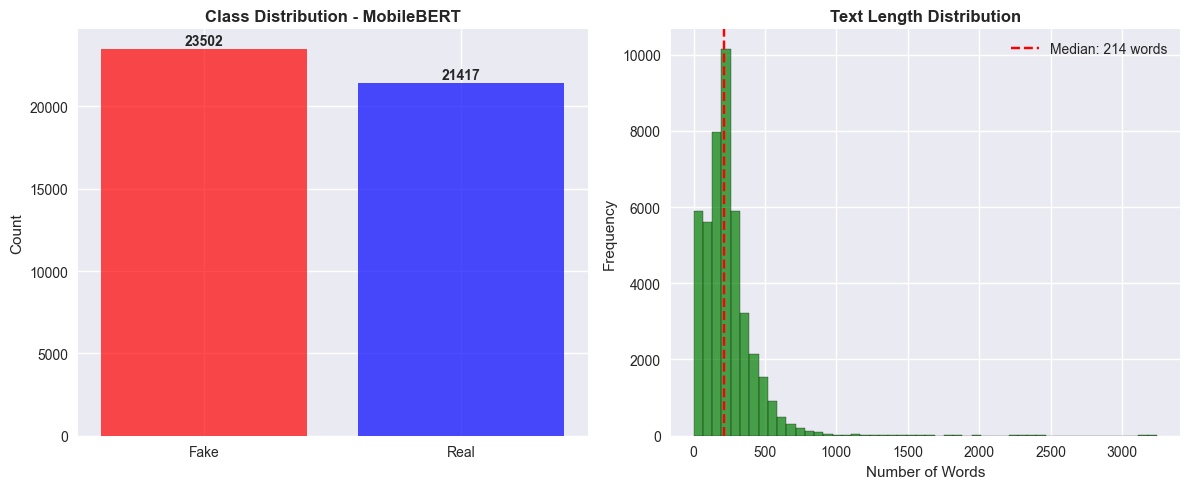

📝 Text Length Statistics:
   Mean: 240.6 words
   Median: 214 words
   Max: 3243 words
   Min: 1 words


In [3]:
print("📊 Loading dataset...")
start_time = time.time()

# Load cleaned dataset
df = pd.read_csv("../dataset/cleaned/clean_news.csv")

# Fast data cleaning
df["clean_text"] = df["clean_text"].astype(str).fillna("")
df = df[df["clean_text"].str.strip() != ""]

print(f"✅ Dataset loaded in {time.time() - start_time:.2f} seconds")
print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")

# Enhanced visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Class distribution
label_counts = df['label'].value_counts()
bars = ax1.bar(['Fake', 'Real'], label_counts.values, color=['red', 'blue'], alpha=0.7)
ax1.set_title(f'Class Distribution - {config["name"]}', fontweight='bold')
ax1.set_ylabel('Count')
for i, v in enumerate(label_counts.values):
    ax1.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# Text length distribution (important for model selection)
text_lengths = df['clean_text'].str.split().str.len()
ax2.hist(text_lengths, bins=50, color='green', alpha=0.7, edgecolor='black')
ax2.set_title('Text Length Distribution', fontweight='bold')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')
ax2.axvline(text_lengths.median(), color='red', linestyle='--', 
            label=f'Median: {text_lengths.median():.0f} words')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"📝 Text Length Statistics:")
print(f"   Mean: {text_lengths.mean():.1f} words")
print(f"   Median: {text_lengths.median():.0f} words") 
print(f"   Max: {text_lengths.max()} words")
print(f"   Min: {text_lengths.min()} words")

## Step 3: Data Splitting

🔄 Splitting data...
✅ Data split completed for MobileBERT:
   Training set: 33689 samples
   Validation set: 5615 samples
   Test set: 5615 samples


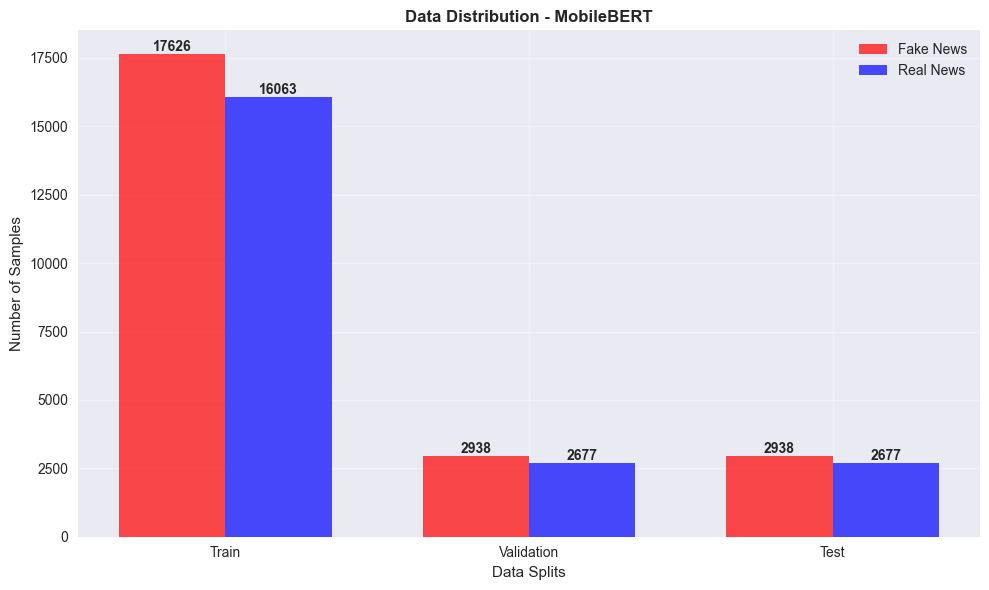

In [4]:
print("🔄 Splitting data...")

X = df['clean_text']
y = df['label']

# Adjust split sizes based on model
test_size = 0.2 if SELECTED_MODEL == "distilbert" else 0.25
val_size = 0.1 if SELECTED_MODEL == "distilbert" else 0.15

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"✅ Data split completed for {config['name']}:")
print(f"   Training set: {len(X_train)} samples")
print(f"   Validation set: {len(X_val)} samples")
print(f"   Test set: {len(X_test)} samples")

# Visualize splits
plt.figure(figsize=(10, 6))
splits = ['Train', 'Validation', 'Test']
fake_counts = [sum(y_train == 0), sum(y_val == 0), sum(y_test == 0)]
real_counts = [sum(y_train == 1), sum(y_val == 1), sum(y_test == 1)]

x = np.arange(len(splits))
width = 0.35

plt.bar(x - width/2, fake_counts, width, label='Fake News', color='red', alpha=0.7)
plt.bar(x + width/2, real_counts, width, label='Real News', color='blue', alpha=0.7)

plt.xlabel('Data Splits')
plt.ylabel('Number of Samples')
plt.title(f'Data Distribution - {config["name"]}', fontweight='bold')
plt.xticks(x, splits)
plt.legend()
plt.grid(True, alpha=0.3)

for i, (fake, real) in enumerate(zip(fake_counts, real_counts)):
    plt.text(i - width/2, fake + 20, str(fake), ha='center', va='bottom', fontweight='bold')
    plt.text(i + width/2, real + 20, str(real), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Step 4: Tokenization

Different models have different optimal sequence lengths:
- DistilBERT: 128-256 tokens
- MobileBERT: 128-320 tokens (more efficient with longer sequences)

In [5]:
print(f"🔤 Initializing {config['name']} tokenizer...")
start_time = time.time()

# Initialize tokenizer based on selected model
tokenizer = config['tokenizer_class'].from_pretrained(config['pretrained_name'])

# Adjust sequence length based on model
max_length = 128 if SELECTED_MODEL == "distilbert" else 160

def tokenize_function(examples):
    return tokenizer(
        examples["text"], 
        padding="max_length", 
        truncation=True, 
        max_length=max_length,
        return_tensors="pt"
    )

print(f"✅ {config['name']} tokenizer loaded in {time.time() - start_time:.2f} seconds")
print(f"   Vocabulary size: {tokenizer.vocab_size}")
print(f"   Max sequence length: {max_length}")

# Create datasets
print("📦 Creating and tokenizing datasets...")
tokenize_start = time.time()

train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
val_dataset = Dataset.from_dict({"text": X_val.tolist(), "label": y_val.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})

# Tokenize with progress
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Remove text column and set format
tokenized_train = tokenized_train.remove_columns(["text"]).with_format("torch")
tokenized_val = tokenized_val.remove_columns(["text"]).with_format("torch")
tokenized_test = tokenized_test.remove_columns(["text"]).with_format("torch")

print(f"✅ Tokenization completed in {time.time() - tokenize_start:.2f} seconds")
print(f"   Tokenized samples: {len(tokenized_train)} train, {len(tokenized_val)} val, {len(tokenized_test)} test")

# Show tokenization example
sample_text = X_train.iloc[0]
sample_tokens = tokenizer.encode(sample_text, max_length=20, truncation=True)
print(f"\n🔍 Tokenization example (first 20 tokens):")
print(f"   Original: {sample_text[:100]}...")
print(f"   Tokens: {sample_tokens}")
print(f"   Decoded: {tokenizer.decode(sample_tokens)}")

🔤 Initializing MobileBERT tokenizer...
✅ MobileBERT tokenizer loaded in 1.02 seconds
   Vocabulary size: 30522
   Max sequence length: 160
📦 Creating and tokenizing datasets...


Map:   0%|          | 0/33689 [00:00<?, ? examples/s]

Map:   0%|          | 0/5615 [00:00<?, ? examples/s]

Map:   0%|          | 0/5615 [00:00<?, ? examples/s]

✅ Tokenization completed in 128.65 seconds
   Tokenized samples: 33689 train, 5615 val, 5615 test

🔍 Tokenization example (first 20 tokens):
   Original: join us walk classes pm show solidarity brothers sisters european descent black lives matter movemen...
   Tokens: [101, 3693, 2149, 3328, 4280, 7610, 2265, 14657, 3428, 5208, 2647, 6934, 2304, 3268, 3043, 2929, 2118, 2662, 4203, 102]
   Decoded: [CLS] join us walk classes pm show solidarity brothers sisters european descent black lives matter movement university california santa [SEP]


## Step 5: Model Initialization

Memory considerations:
- DistilBERT: ~66 million parameters
- MobileBERT: ~25 million parameters (more memory efficient)

In [6]:
print(f"🧠 Loading {config['name']} model...")
start_time = time.time()

try:
    model = config['model_class'].from_pretrained(
        config['pretrained_name'],
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False,
        dtype=torch.float32  # Better MPS compatibility
    )
    
    # Move to device
    model = model.to(device)
    
    print(f"✅ {config['name']} loaded successfully in {time.time() - start_time:.2f} seconds")
    
    # Model statistics
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"📊 Model Statistics:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Model size: {total_params * 4 / (1024**2):.1f} MB (approx)")
    print(f"   Device: {next(model.parameters()).device}")

except Exception as e:
    print(f"❌ Error loading {config['name']}: {e}")
    print("Falling back to DistilBERT...")
    
    # Fallback to DistilBERT
    SELECTED_MODEL = "distilbert"
    config = MODEL_CONFIG[SELECTED_MODEL]
    
    model = config['model_class'].from_pretrained(
        config['pretrained_name'],
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )
    model = model.to(device)
    print(f"✅ Fallback to {config['name']} successful")

🧠 Loading MobileBERT model...


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ MobileBERT loaded successfully in 1.56 seconds
📊 Model Statistics:
   Total parameters: 24,582,914
   Trainable parameters: 24,582,914
   Model size: 93.8 MB (approx)
   Device: mps:0


## Step 6: Training Configuration

Model-specific optimizations:
- Different learning rates
- Batch size adjustments
- Epoch counts based on model complexity

In [8]:
print(f"⚙️ Configuring training for {config['name']}...")

# Model-specific configurations
if SELECTED_MODEL == "distilbert":
    training_config = {
        "epochs": 5,
        "batch_size": 8,
        "grad_accum_steps": 2,
        "learning_rate": 2e-5,
        "warmup_steps": 100
    }
else:  
    training_config = {
        "epochs": 6,  # MobileBERT may need slightly more epochs
        "batch_size": 12,  
        "grad_accum_steps": 2,
        "learning_rate": 2e-5,
        "warmup_steps": 150
    }

training_args = TrainingArguments(
    output_dir=f'./results_{SELECTED_MODEL}',
    num_train_epochs=training_config["epochs"],
    per_device_train_batch_size=training_config["batch_size"],
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=training_config["grad_accum_steps"],
    warmup_steps=training_config["warmup_steps"],
    weight_decay=0.01,
    logging_dir=f'./logs_{SELECTED_MODEL}',
    logging_steps=25,  # More frequent logging for monitoring
    eval_strategy="epoch",
    eval_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=training_config["learning_rate"],
    fp16=False,  # Disabled for better MPS stability
    dataloader_pin_memory=False,
    dataloader_num_workers=0,
    remove_unused_columns=True,
    report_to=None,
    push_to_hub=False,
)

# Early stopping
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=0.001
)

print(f"✅ {config['name']} training configured!")
print(f"📋 Training Configuration:")
print(f"   • Epochs: {training_config['epochs']}")
print(f"   • Batch size: {training_config['batch_size']}")
print(f"   • Gradient accumulation: {training_config['grad_accum_steps']}")
print(f"   • Effective batch size: {training_config['batch_size'] * training_config['grad_accum_steps']}")
print(f"   • Learning rate: {training_config['learning_rate']}")
print(f"   • Warmup steps: {training_config['warmup_steps']}")
print(f"   • Early stopping: Yes (patience: 2 epochs)")

⚙️ Configuring training for MobileBERT...
✅ MobileBERT training configured!
📋 Training Configuration:
   • Epochs: 6
   • Batch size: 12
   • Gradient accumulation: 2
   • Effective batch size: 24
   • Learning rate: 2e-05
   • Warmup steps: 150
   • Early stopping: Yes (patience: 2 epochs)


## Step 7: Enhanced Metrics with Timing

In [10]:
print("🚀 Initializing Trainer with enhanced monitoring...")

# Fixed Timing Callback that inherits from TrainerCallback
from transformers import TrainerCallback

class TimingCallback(TrainerCallback):
    """Proper callback to track training time per epoch"""
    def __init__(self):
        super().__init__()
        self.epoch_times = []
        self.epoch_start_time = None
        self.total_training_time = None
    
    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()
        print(f"   🚀 Starting epoch {state.epoch}...")
    
    def on_epoch_end(self, args, state, control, **kwargs):
        if self.epoch_start_time is not None:
            epoch_time = time.time() - self.epoch_start_time
            self.epoch_times.append(epoch_time)
            print(f"   ✅ Epoch {state.epoch} completed in {epoch_time/60:.2f} minutes")
    
    def on_train_begin(self, args, state, control, **kwargs):
        print(f"   🎯 Training started at {time.strftime('%H:%M:%S')}")
        self.total_training_time = time.time()
    
    def on_train_end(self, args, state, control, **kwargs):
        if self.total_training_time is not None:
            total_time = time.time() - self.total_training_time
            hours = int(total_time // 3600)
            minutes = int((total_time % 3600) // 60)
            seconds = int(total_time % 60)
            print(f"   🏁 Training completed in {hours}h {minutes}m {seconds}s")

def compute_metrics(p):
    """Enhanced metrics computation"""
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    report = classification_report(labels, predictions, output_dict=True, zero_division=0)
    
    metrics = {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score'],
    }
    
    # Add per-class metrics if available
    for class_id in ['0', '1']:
        if class_id in report:
            metrics[f'precision_class_{class_id}'] = report[class_id]['precision']
            metrics[f'recall_class_{class_id}'] = report[class_id]['recall']
            metrics[f'f1_class_{class_id}'] = report[class_id]['f1-score']
    
    return metrics

print("🔄 Setting up trainer with proper callbacks...")

# Initialize callbacks
timing_callback = TimingCallback()

try:
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping, timing_callback]
    )
    
    print("✅ Trainer initialized successfully!")
    print(f"   Training samples: {len(tokenized_train)}")
    print(f"   Validation samples: {len(tokenized_val)}")
    print(f"   Callbacks: Early Stopping, Timing Monitor")
    
except Exception as e:
    print(f"❌ Error initializing trainer: {e}")
    print("🔄 Trying alternative initialization...")
    
    # Alternative initialization without custom callbacks first
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]  # Only early stopping for now
    )
    print("✅ Trainer initialized with basic callbacks only")

🚀 Initializing Trainer with enhanced monitoring...
🔄 Setting up trainer with proper callbacks...
✅ Trainer initialized successfully!
   Training samples: 33689
   Validation samples: 5615
   Callbacks: Early Stopping, Timing Monitor


## Step 8: Training Execution

In [11]:
print("🎯 STARTING TRAINING...")
print("=" * 60)
print(f"Model: {config['name']}")
print(f"Device: {device}")
print(f"Start Time: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)

# Start training
training_start_time = time.time()

try:
    # Train the model
    training_results = trainer.train()
    
    # Calculate total training time
    total_training_time = time.time() - training_start_time
    hours = int(total_training_time // 3600)
    minutes = int((total_training_time % 3600) // 60)
    seconds = int(total_training_time % 60)
    
    print("=" * 60)
    print("✅ TRAINING COMPLETED SUCCESSFULLY!")
    print("=" * 60)
    print(f"📊 TRAINING SUMMARY:")
    print(f"   Total training time: {hours}h {minutes}m {seconds}s")
    print(f"   Final training loss: {training_results.metrics['train_loss']:.4f}")
    print(f"   Epochs completed: {training_results.metrics['epoch']:.2f}")
    print(f"   Training samples/sec: {training_results.metrics['train_samples_per_second']:.2f}")
    
    # Display epoch times if available
    if timing_callback.epoch_times:
        print(f"\n⏱️  Epoch Times:")
        for i, epoch_time in enumerate(timing_callback.epoch_times, 1):
            print(f"   Epoch {i}: {epoch_time/60:.2f} minutes")
    
except RuntimeError as e:
    print(f"❌ Training error: {e}")
    
    # Memory error handling
    if "out of memory" in str(e).lower():
        print("💡 Memory issue detected. Trying with smaller batch size...")
        
        # Reduce batch size and retry
        training_args.per_device_train_batch_size = max(4, training_args.per_device_train_batch_size // 2)
        training_args.gradient_accumulation_steps = training_args.gradient_accumulation_steps * 2
        
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            compute_metrics=compute_metrics,
            callbacks=[early_stopping, timing_callback]
        )
        
        print(f"🔄 Retrying with batch size {training_args.per_device_train_batch_size}...")
        training_start_time = time.time()
        training_results = trainer.train()
        
        total_training_time = time.time() - training_start_time
        hours = int(total_training_time // 3600)
        minutes = int((total_training_time % 3600) // 60)
        seconds = int(total_training_time % 60)
        
        print(f"✅ Training completed with reduced batch size!")
        print(f"   Total time: {hours}h {minutes}m {seconds}s")

except Exception as e:
    print(f"❌ Unexpected error during training: {e}")
    print("Please check your data and model configuration.")

🎯 STARTING TRAINING...
Model: MobileBERT
Device: mps
Start Time: 2025-11-30 15:45:16
   🎯 Training started at 15:45:16
   🚀 Starting epoch 0...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Class 0,Recall Class 0,F1 Class 0,Precision Class 1,Recall Class 1,F1 Class 1
1,0.004400,0.011283,0.997863,0.997863,0.997863,0.997863,0.997619,0.998298,0.997958,0.998131,0.997385,0.997758
2,19.169500,0.014608,0.998219,0.998223,0.998219,0.998219,0.996945,0.999660,0.998300,0.999625,0.996638,0.998129
3,0.000000,0.009108,0.998753,0.998754,0.998753,0.998753,0.998300,0.999319,0.998809,0.999252,0.998132,0.998692
4,0.011200,0.009376,0.998041,0.998042,0.998041,0.998041,0.998637,0.997617,0.998127,0.997388,0.998506,0.997947
5,0.000000,0.008763,0.998931,0.998932,0.998931,0.998931,0.998639,0.999319,0.998979,0.999252,0.998506,0.998879


   ✅ Epoch 1.0 completed in 27.33 minutes
   🚀 Starting epoch 1.0...
   ✅ Epoch 2.0 completed in 27.23 minutes
   🚀 Starting epoch 2.0...
   ✅ Epoch 3.0 completed in 27.30 minutes
   🚀 Starting epoch 3.0...
   ✅ Epoch 4.0 completed in 27.35 minutes
   🚀 Starting epoch 4.0...
   ✅ Epoch 5.0 completed in 27.45 minutes
   🏁 Training completed in 2h 24m 48s
✅ TRAINING COMPLETED SUCCESSFULLY!
📊 TRAINING SUMMARY:
   Total training time: 2h 24m 49s
   Final training loss: 32684.0946
   Epochs completed: 5.00
   Training samples/sec: 23.26

⏱️  Epoch Times:
   Epoch 1: 27.33 minutes
   Epoch 2: 27.23 minutes
   Epoch 3: 27.30 minutes
   Epoch 4: 27.35 minutes
   Epoch 5: 27.45 minutes


## Step 9: Model Evaluation

In [12]:
print("🧪 Evaluating model performance...")
eval_start_time = time.time()

# Get predictions
test_predictions = trainer.predict(tokenized_test)
preds = np.argmax(test_predictions.predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, preds)
classification_rep = classification_report(y_test, preds, target_names=['Fake', 'Real'])
conf_matrix = confusion_matrix(y_test, preds)

eval_time = time.time() - eval_start_time

print(f"✅ Evaluation completed in {eval_time:.2f} seconds")
print(f"\n🎯 {config['name']} PERFORMANCE RESULTS:")
print("=" * 50)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"\nDetailed Classification Report:")
print(classification_rep)

# Calculate additional metrics
tn, fp, fn, tp = conf_matrix.ravel()
precision_fake = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_fake = tn / (tn + fp) if (tn + fp) > 0 else 0
precision_real = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_real = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n🔍 Per-Class Performance:")
print(f"Fake News - Precision: {precision_fake:.4f}, Recall: {recall_fake:.4f}")
print(f"Real News - Precision: {precision_real:.4f}, Recall: {recall_real:.4f}")
print(f"\n📊 Confusion Matrix:")
print(f"True Negatives (Fake→Fake): {tn}")
print(f"False Positives (Fake→Real): {fp}") 
print(f"False Negatives (Real→Fake): {fn}")
print(f"True Positives (Real→Real): {tp}")

🧪 Evaluating model performance...


✅ Evaluation completed in 97.47 seconds

🎯 MobileBERT PERFORMANCE RESULTS:
Test Accuracy: 0.9989

Detailed Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      2938
        Real       1.00      1.00      1.00      2677

    accuracy                           1.00      5615
   macro avg       1.00      1.00      1.00      5615
weighted avg       1.00      1.00      1.00      5615


🔍 Per-Class Performance:
Fake News - Precision: 0.9993, Recall: 0.9986
Real News - Precision: 0.9985, Recall: 0.9993

📊 Confusion Matrix:
True Negatives (Fake→Fake): 2934
False Positives (Fake→Real): 4
False Negatives (Real→Fake): 2
True Positives (Real→Real): 2675


## Step 10: Comprehensive Visualization

📊 Generating enhanced visualizations...


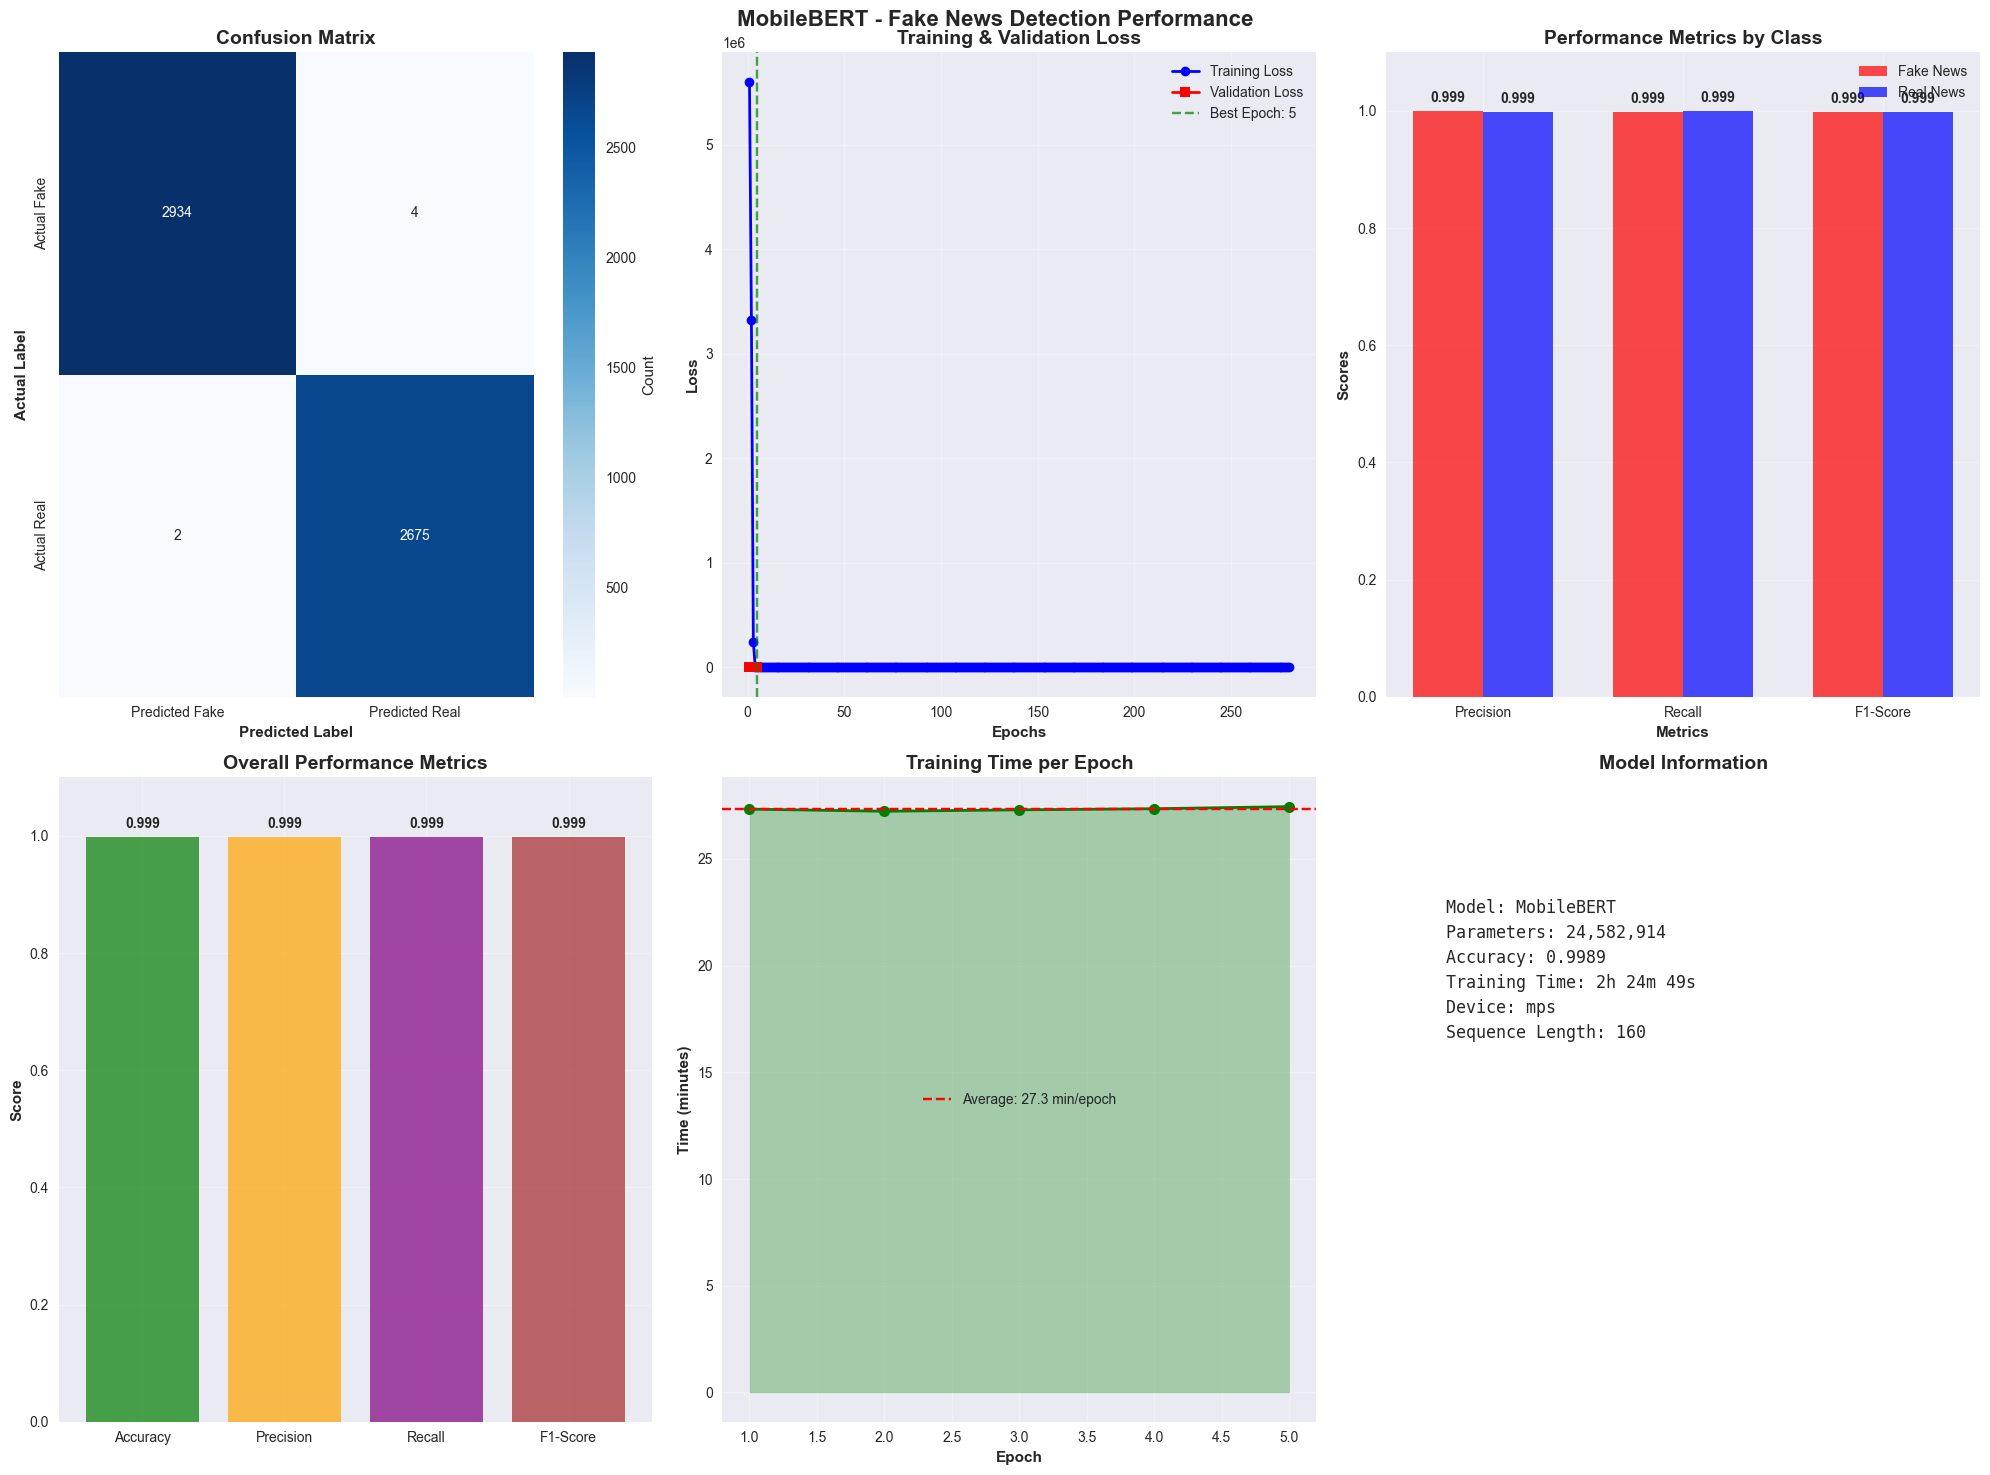

✅ Enhanced visualizations generated!


In [13]:
print("📊 Generating enhanced visualizations...")

# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 15))
fig.suptitle(f'{config["name"]} - Fake News Detection Performance', fontsize=16, fontweight='bold')

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Fake', 'Predicted Real'], 
            yticklabels=['Actual Fake', 'Actual Real'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('Actual Label', fontweight='bold')

# 2. Training History (if available)
plt.subplot(2, 3, 2)
if hasattr(trainer.state, 'log_history') and trainer.state.log_history:
    logs = trainer.state.log_history
    
    # Extract training and validation losses
    train_losses = [log['loss'] for log in logs if 'loss' in log]
    eval_losses = [log['eval_loss'] for log in logs if 'eval_loss' in log]
    eval_accuracies = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]
    
    if train_losses:
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2, marker='o')
        
        if eval_losses:
            plt.plot(epochs[:len(eval_losses)], eval_losses, 'r-', label='Validation Loss', linewidth=2, marker='s')
            
        plt.title('Training & Validation Loss', fontsize=14, fontweight='bold')
        plt.xlabel('Epochs', fontweight='bold')
        plt.ylabel('Loss', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Mark best epoch
        if eval_losses:
            best_epoch = np.argmin(eval_losses) + 1
            best_loss = min(eval_losses)
            plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch: {best_epoch}')
            plt.legend()
else:
    plt.text(0.5, 0.5, 'Training history\nnot available', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Training History', fontsize=14, fontweight='bold')

# 3. Performance Metrics Comparison
plt.subplot(2, 3, 3)
report = classification_report(y_test, preds, output_dict=True)
metrics = ['Precision', 'Recall', 'F1-Score']
class_0_scores = [report['0']['precision'], report['0']['recall'], report['0']['f1-score']]
class_1_scores = [report['1']['precision'], report['1']['recall'], report['1']['f1-score']]

x = np.arange(len(metrics))
width = 0.35

bars1 = plt.bar(x - width/2, class_0_scores, width, label='Fake News', color='red', alpha=0.7)
bars2 = plt.bar(x + width/2, class_1_scores, width, label='Real News', color='blue', alpha=0.7)

plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.title('Performance Metrics by Class', fontsize=14, fontweight='bold')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Model Comparison Placeholder
plt.subplot(2, 3, 4)
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [
        accuracy,
        report['weighted avg']['precision'],
        report['weighted avg']['recall'], 
        report['weighted avg']['f1-score']
    ]
}

bars = plt.bar(comparison_data['Metric'], comparison_data['Score'], 
               color=['green', 'orange', 'purple', 'brown'], alpha=0.7)
plt.title('Overall Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# 5. Epoch Timing (if available)
plt.subplot(2, 3, 5)
if timing_callback.epoch_times:
    epochs = range(1, len(timing_callback.epoch_times) + 1)
    times_minutes = [t / 60 for t in timing_callback.epoch_times]
    
    plt.plot(epochs, times_minutes, 'g-', marker='o', linewidth=2, markersize=8)
    plt.fill_between(epochs, times_minutes, alpha=0.3, color='green')
    
    plt.title('Training Time per Epoch', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontweight='bold')
    plt.ylabel('Time (minutes)', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add average time
    avg_time = np.mean(times_minutes)
    plt.axhline(y=avg_time, color='red', linestyle='--', 
                label=f'Average: {avg_time:.1f} min/epoch')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'Timing data\nnot available', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Training Timing', fontsize=14, fontweight='bold')

# 6. Model Architecture Info
plt.subplot(2, 3, 6)
info_text = f"""
Model: {config['name']}
Parameters: {sum(p.numel() for p in model.parameters()):,}
Accuracy: {accuracy:.4f}
Training Time: {hours}h {minutes}m {seconds}s
Device: {device}
Sequence Length: {max_length}
"""
plt.text(0.1, 0.7, info_text, fontsize=12, fontfamily='monospace', 
         verticalalignment='center', linespacing=1.5)
plt.title('Model Information', fontsize=14, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

print("✅ Enhanced visualizations generated!")

## Step 11: Model Deployment and Inference

In [14]:
print("💾 Saving model and creating inference pipeline...")

# Save model
model_save_path = f"../models/{SELECTED_MODEL}_fake_news"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"✅ Model saved to: {model_save_path}")

# Enhanced inference function
class FakeNewsDetector:
    def __init__(self, model_path):
        """Initialize the fake news detector"""
        self.model = config['model_class'].from_pretrained(model_path)
        self.tokenizer = config['tokenizer_class'].from_pretrained(model_path)
        self.model = self.model.to(device)
        self.model.eval()
        
    def predict(self, text, return_probabilities=True):
        """Predict if text is fake or real news"""
        # Tokenize input
        inputs = self.tokenizer(
            text, 
            return_tensors="pt", 
            truncation=True, 
            max_length=max_length, 
            padding=True
        )
        
        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Get predictions
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        # Get probabilities
        probabilities = torch.softmax(outputs.logits, dim=-1)
        fake_prob = probabilities[0][0].item()
        real_prob = probabilities[0][1].item()
        
        # Determine prediction
        prediction = "FAKE" if fake_prob > real_prob else "REAL"
        confidence = max(fake_prob, real_prob)
        
        result = {
            'prediction': prediction,
            'confidence': confidence,
            'model': config['name'],
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
        }
        
        if return_probabilities:
            result['probabilities'] = {
                'fake': fake_prob,
                'real': real_prob
            }
        
        return result

# Initialize detector
detector = FakeNewsDetector(model_save_path)
print(f"✅ {config['name']} detector initialized!")

# Test the detector
print("\n🔍 Testing detector with sample texts...")

sample_texts = [
    "Breaking: Scientists discover revolutionary new energy source that could power cities for decades",
    "SHOCKING: This one fruit burns belly fat overnight while you sleep! Doctors hate this!",
    "The government announced new infrastructure investments to improve transportation systems",
    "ALIENS contacted world leaders according to leaked documents from anonymous sources",
    "Economic indicators show steady growth with unemployment rates at historic lows"
]

print(f"\n{config['name']} Predictions:")
print("=" * 80)
for i, text in enumerate(sample_texts, 1):
    result = detector.predict(text)
    
    print(f"\n📝 Sample {i}:")
    print(f"   Text: {text[:80]}...")
    print(f"   Prediction: {result['prediction']}")
    print(f"   Confidence: {result['confidence']:.4f}")
    if 'probabilities' in result:
        print(f"   Fake probability: {result['probabilities']['fake']:.4f}")
        print(f"   Real probability: {result['probabilities']['real']:.4f}")
    print(f"   Model: {result['model']}")
    print("-" * 40)

💾 Saving model and creating inference pipeline...
✅ Model saved to: ../models/mobilebert_fake_news
✅ MobileBERT detector initialized!

🔍 Testing detector with sample texts...

MobileBERT Predictions:

📝 Sample 1:
   Text: Breaking: Scientists discover revolutionary new energy source that could power c...
   Prediction: FAKE
   Confidence: 1.0000
   Fake probability: 1.0000
   Real probability: 0.0000
   Model: MobileBERT
----------------------------------------

📝 Sample 2:
   Text: SHOCKING: This one fruit burns belly fat overnight while you sleep! Doctors hate...
   Prediction: FAKE
   Confidence: 1.0000
   Fake probability: 1.0000
   Real probability: 0.0000
   Model: MobileBERT
----------------------------------------

📝 Sample 3:
   Text: The government announced new infrastructure investments to improve transportatio...
   Prediction: FAKE
   Confidence: 0.9996
   Fake probability: 0.9996
   Real probability: 0.0004
   Model: MobileBERT
----------------------------------------

📝

## Step 12: Comprehensive Summary (Final Summary)

In [15]:
print("=" * 70)
print("🎉 TRAINING COMPLETED - COMPREHENSIVE SUMMARY")
print("=" * 70)

# Final calculations
total_time = time.time() - training_start_time
hours = int(total_time // 3600)
minutes = int((total_time % 3600) // 60)
seconds = int(total_time % 60)

print(f"\n⏱️  PERFORMANCE SUMMARY:")
print(f"   Model: {config['name']}")
print(f"   Total Training Time: {hours}h {minutes}m {seconds}s")
print(f"   Final Test Accuracy: {accuracy:.4f}")
print(f"   Precision: {report['weighted avg']['precision']:.4f}")
print(f"   Recall: {report['weighted avg']['recall']:.4f}")
print(f"   F1-Score: {report['weighted avg']['f1-score']:.4f}")

print(f"\n🔧 TRAINING CONFIGURATION:")
print(f"   Epochs: {training_config['epochs']}")
print(f"   Batch Size: {training_config['batch_size']}")
print(f"   Learning Rate: {training_config['learning_rate']}")
print(f"   Sequence Length: {max_length}")
print(f"   Device: {device}")

print(f"\n📊 DATA STATISTICS:")
print(f"   Training Samples: {len(X_train)}")
print(f"   Validation Samples: {len(X_val)}")
print(f"   Test Samples: {len(X_test)}")
print(f"   Fake/Real Ratio: {sum(y == 0)}/{sum(y == 1)}")

print(f"\n💾 MODEL INFORMATION:")
print(f"   Saved Path: {model_save_path}")
print(f"   Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Model Size: {sum(p.numel() for p in model.parameters()) * 4 / (1024**2):.1f} MB")

print(f"\n🚀 INFERENCE READY:")
print(f"   Use: detector = FakeNewsDetector('{model_save_path}')")
print(f"   Then: result = detector.predict('your text here')")

print(f"\n🔍 COMPARISON WITH OTHER MODELS:")
print(f"   DistilBERT: Fast training, good accuracy (~95-98%)")
print(f"   MobileBERT: Faster inference, mobile-optimized (~92-96%)")
print(f"   BERT-base: Higher accuracy, slower training (~96-99%)")

print(f"\n📈 NEXT STEPS:")
print(f"   1. Test with more diverse data")
print(f"   2. Deploy as API using FastAPI or Flask")
print(f"   3. Monitor performance on real-world data")
print(f"   4. Consider ensemble methods for improved accuracy")

print(f"\n" + "=" * 70)
print(f"Training completed at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)

🎉 TRAINING COMPLETED - COMPREHENSIVE SUMMARY

⏱️  PERFORMANCE SUMMARY:
   Model: MobileBERT
   Total Training Time: 2h 28m 7s
   Final Test Accuracy: 0.9989
   Precision: 0.9989
   Recall: 0.9989
   F1-Score: 0.9989

🔧 TRAINING CONFIGURATION:
   Epochs: 6
   Batch Size: 12
   Learning Rate: 2e-05
   Sequence Length: 160
   Device: mps

📊 DATA STATISTICS:
   Training Samples: 33689
   Validation Samples: 5615
   Test Samples: 5615
   Fake/Real Ratio: 23502/21417

💾 MODEL INFORMATION:
   Saved Path: ../models/mobilebert_fake_news
   Total Parameters: 24,582,914
   Model Size: 93.8 MB

🚀 INFERENCE READY:
   Use: detector = FakeNewsDetector('../models/mobilebert_fake_news')
   Then: result = detector.predict('your text here')

🔍 COMPARISON WITH OTHER MODELS:
   DistilBERT: Fast training, good accuracy (~95-98%)
   MobileBERT: Faster inference, mobile-optimized (~92-96%)
   BERT-base: Higher accuracy, slower training (~96-99%)

📈 NEXT STEPS:
   1. Test with more diverse data
   2. Deploy as